### Friday Harbor

<p align="center">
<img src="https://www.unavco.org/lib/images/dims/main.php?g2_view=core.DownloadItem&g2_itemId=449171" width="500"/>
</P>

**Station Name:** sc02

**Location:** Friday Harbor, Washington, USA 

**Archive:** [UNAVCO](http://www.unavco.org)

**Ellipsoidal Coordinates:**

- Latitude: 48.546

- Longitude: -123.008  

- Height: -15.049 m

[Station Page at UNAVCO](https://www.unavco.org/instrumentation/networks/status/nota/overview/SC02)

[Station Page at Nevada Geodetic Laboratory](http://geodesy.unr.edu/NGLStationPages/stations/SC02.sta)

[Colocated NOAA tide gauge](https://tidesandcurrents.noaa.gov/stationhome.html?id=9449880)

[Google Maps](https://www.google.com/maps/place/48°32'45.6%22N+123°00'28.8%22W/@48.546,-123.010194,17z/data=!3m1!4b1!4m5!3m4!1s0x0:0x0!8m2!3d48.546!4d-123.008)


In [1]:
import ipywidgets as widgets
import os

from pathlib import Path

from gnssrefl.utils import check_environment, set_environment, get_sys

notebook_dir = Path.cwd().parents[1]

# Making sure environment variables are set - this is required to run the gnssrefl code
exists = check_environment()
if exists == False:
    set_environment(refl_code=str(notebook_dir),
                    orbits=str(notebook_dir / "orbits"),
                    exe=str(notebook_dir / "exe"))
    
#If you are running this locally - make sure the items in the exe folder have execution permissions

# Set local variable of refl_code location
refl_code_loc = os.environ['REFL_CODE']
print("refl_code location:", refl_code_loc)

# import gnssrefl functions
from gnssrefl.installexe_cl import installexe
from gnssrefl.rinex2snr_cl import rinex2snr
from gnssrefl.quickLook_cl import quicklook
from gnssrefl.gnssir_cl import gnssir
from gnssrefl.gnssir_input import make_gnssir_input
from gnssrefl.subdaily_cl import subdaily


# import the crx2rnx file which is dependent on your working OS - this is required to run the gnssrefl code
# If in docker environment, then you do not need to download crxnrnx
try:
    os.environ['DOCKER']
except KeyError:
    sys = get_sys()
    installexe(sys)

environment variable ORBITS set to path /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits 
environment variable REFL_CODE set to path /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks 
environment variable EXE set to path /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/exe
refl_code location: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks
Your executable environment area:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/exe
There is no teqc executable for this architecture, so none will be installed.
This Hatanaka executable already exists
The gfzrnx executable already exists


### Data Summary

There have been *a lot* of papers written about sc02. That being said, it is not an ideal GNSS reflections site. It is set 
back a bit too far from the shore - and it would have been far superior for reflections if the antenna were
a bit taller. Furthermore, there are obstructions (docks). For further details, you are encouraged to read 
[this early paper](https://www.kristinelarson.net/wp-content/uploads/2015/12/LarsonRayWilliams-2017-FridayHarbor.pdf) 
summarizing a comparison of 10 years of GNSS-IR results with the colocated tide gauge operated by NOAA. That paper only
used the GPS L1 SNR data.  Since that time a multi-GNSS receiver has been installed and there is an order of 
magnitude increase in the number of useable signals. Here we will only use the low-rate (15 sec) data from this new receiver. 
If you are interested, UNAVCO does have a 1-sec dataset available for use.


Take some time to look at the [reflection zones webapp.](https://gnss-reflections.org/rzones?station=sc02) 
The goal is to play with the different elevation angle settings and azimuths. This screen 
shot shows clearly that not all azimuths are going to work. But it does not tell you which 
elevation angles will be over water and which will not. The default will use mean sea level -
but keep in mind that the reflector heights will not always be at mean sea level. so you might
try using different reflector heights to see how those reflection zones change. We have 
data from the site, so you can check later to see which ones are the limiting reflector 
heights.

In [2]:
%%html
<iframe src="https://gnss-reflections.org/rzones?station=sc02" width="1000" height="700"></iframe>

### Take a quick look at the SNR data

Translate the GPS data for January 15 2021. First you need to make the SNR file:

In [3]:
rinex2snr('sc02', 2021, 15)

sc02  year: 2021  doy: 15 from:  all
Requested a GPS only nav file
Corrupted file/download failures at SOPAC
SOPAC download did not work, so will try CDDIS
Try the gzipped version
Change the filename to what we use  auto0150.21n
Orbit file:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits/2021/nav/auto0150.21n
https://data.unavco.org/archive/gnss/rinex/obs/2021/015/sc020150.21d.Z
Seeking permission from Earthscope to use their archive
To complete the SSO authorization, please visit the following URL in a browser of your choice:
            https://login.earthscope.org/activate?user_code=PDHK-MLDD
            


SUCCESS: SNR file was created 
 /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2021/snr/sc02/sc020150.21.snr66
That took  40.42  seconds
Feedback written to subdirectory logs


Use our utility <code>quickLook</code> with defaults [(For more details on quickLook output)](../../docs/quickLook_desc.md):

minimum elevation angle (degrees) for this dataset:  0.0446
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sc02/quickLook_lsp.png
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sc02/quickLook_summary.png


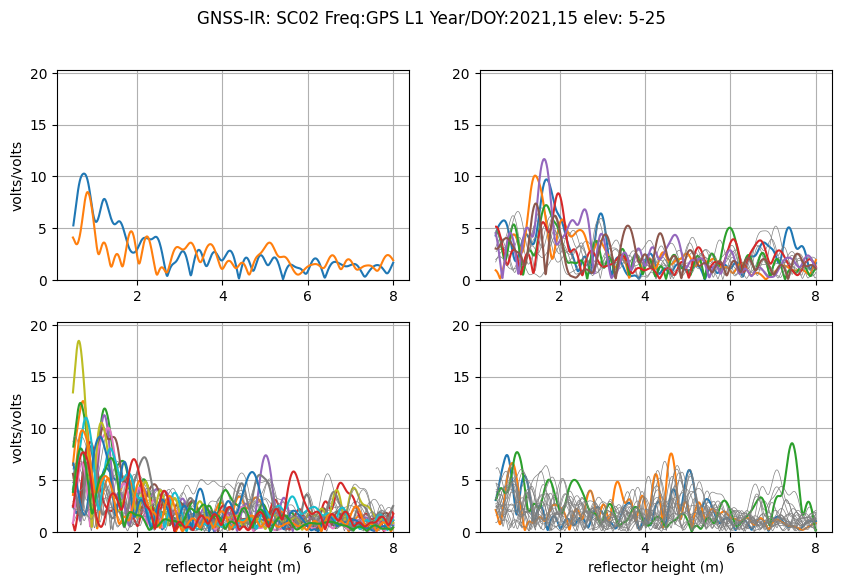

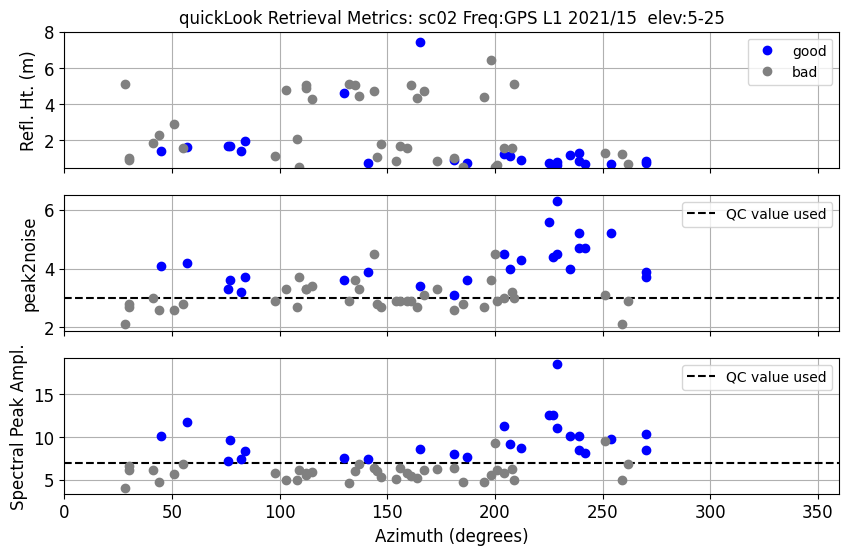

In [4]:
vals, metrics = quicklook('sc02', 2021, 15)

These results for reflector height in the top panel are pretty bad (gray means the retrieval does not pass QC). Why? 
The reflector height defaults are restricted to 0.5-8 meters, which includes part of 
the tidal range, but not all of it. Furthermore, the default elevation angles of 5 to 25 degrees are 
not acceptable here, as these elevation angles include rocks and soil in addition to the water.

Now let's make better choices. Following the suggestions of *Larson, Ray, and Williams* (2017), use 
elevation angle restrictions of 5 to 13 degrees and reflector height restrictions of 3 to 12 meters. And let's 
use a modern GPS signal, L2C.

minimum elevation angle (degrees) for this dataset:  0.0446
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sc02/quickLook_lsp.png
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sc02/quickLook_summary.png


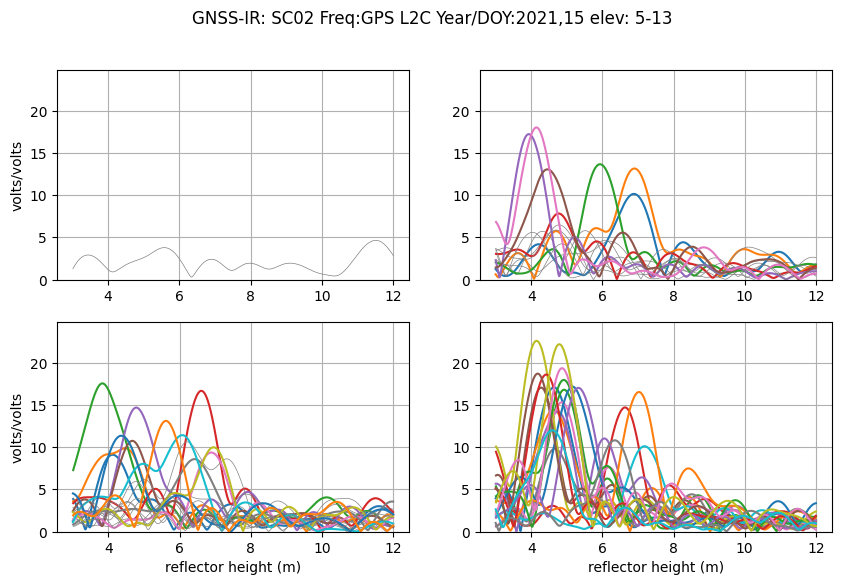

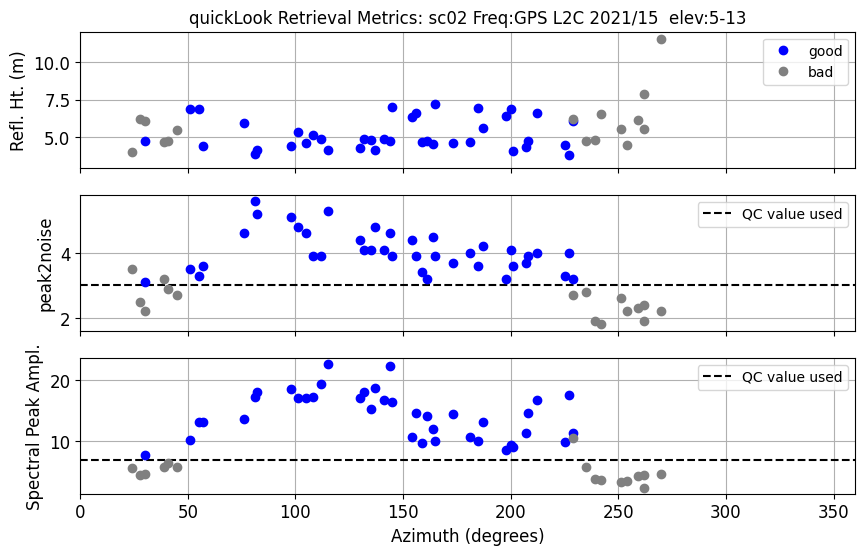

In [5]:
vals, metrics = quicklook('sc02', 2021, 15, e2=13, h1=3, h2=12, fr=20)

Now instead of vast numbers of unsuccessful reflector height retrivals, you can begin to 
see where the acceptable azimuths will be, ~50 to 230 degrees. A peak to noise ratio 
of 3 works pretty well.  The Lomb Scargle periodograms show the 
retrievals in periodogram space. You can see here that the northwest
is a dead zone for water reflections, and that was expected.

We can also check the retrievals stats for L1 to make sure these look good too.

minimum elevation angle (degrees) for this dataset:  0.0446
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sc02/quickLook_lsp.png
plot saved to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sc02/quickLook_summary.png


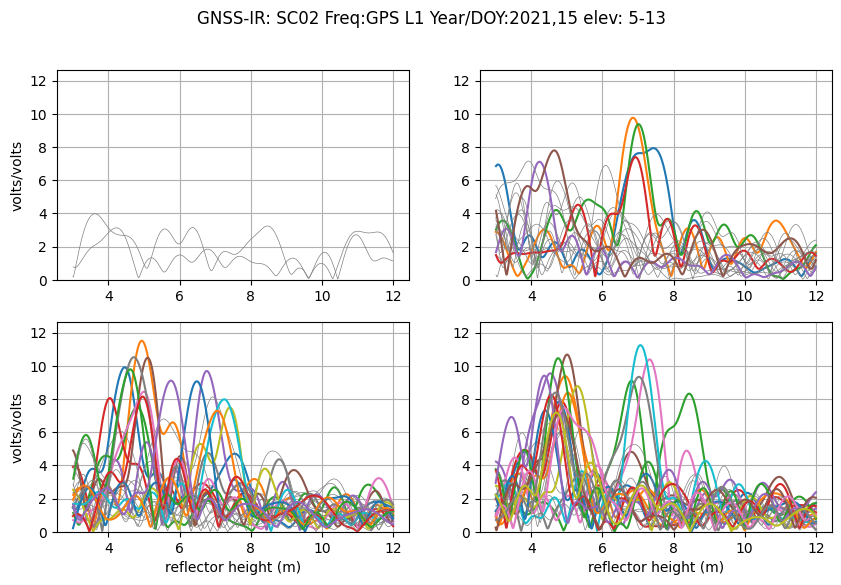

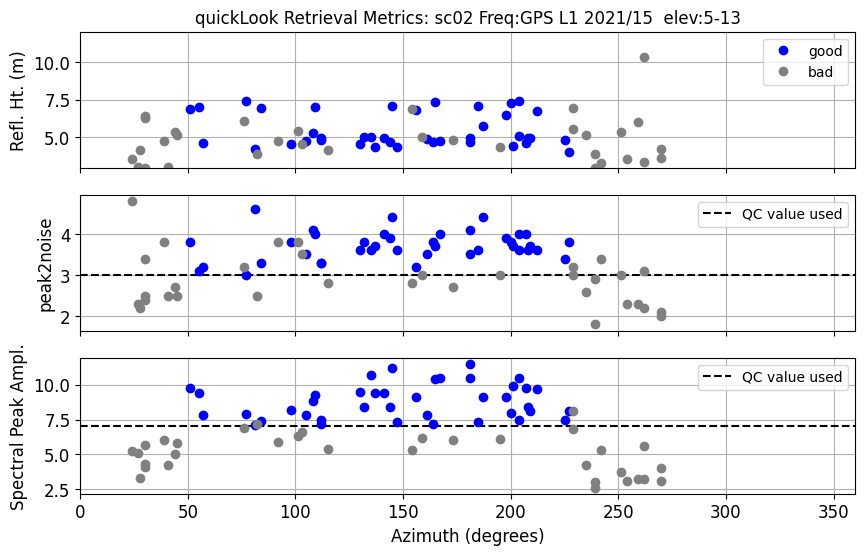

In [6]:
vals, metrics = quicklook('sc02', 2021, 15, e2=13, h1=3, h2=12)

We will not attempt to analyze a long time series, but instead focus here on 
the process. We will be using three+ weeks of GNSS data from 2021 as our sample dataset.

In [7]:
rinex2snr('sc02', 2021, 15, doy_end=40)

SNR file already exists /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2021/snr/sc02/sc020150.21.snr66
sc02  year: 2021  doy: 16 from:  all
Requested a GPS only nav file
Corrupted file/download failures at SOPAC
SOPAC download did not work, so will try CDDIS
Try the gzipped version
Change the filename to what we use  auto0160.21n
Orbit file:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits/2021/nav/auto0160.21n
https://data.unavco.org/archive/gnss/rinex/obs/2021/016/sc020160.21d.Z
Seeking permission from Earthscope to use their archive


SUCCESS: SNR file was created 
 /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/2021/snr/sc02/sc020160.21.snr66
sc02  year: 2021  doy: 17 from:  all
Requested a GPS only nav file
Corrupted file/download failures at SOPAC
SOPAC download did not work, so will try CDDIS
Try the gzipped version
Change the filename to what we use  auto0170.21n
Orbit file:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/orbits/2021/nav/auto0170.21n
h

Then you need to make the list of analysis input:
We will remove the unreliable azimuths and the Beidou signals because they are not in the RINEX 2.11 file.

In [9]:
make_gnssir_input('sc02', e1=5, e2=13, h1=3, h2=12, peak2noise=3.0, frlist=[1,20,5,101,102,201,205,207], azlist2=[60, 220])

Assume you want to use the UNR database.
The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Implementing user-provided frequency list.
writing out to: /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/sc02.json


Once you have the json file set up, you can go ahead and analyze all the data with a single command:

In [10]:
gnssir('sc02', 2021, 15, doy_end=40)

{'station': 'sc02', 'lat': 48.546194747, 'lon': -123.00761051, 'ht': -15.0490625, 'minH': 3, 'maxH': 12, 'e1': 5, 'e2': 13, 'NReg': [3, 12], 'PkNoise': 3.0, 'polyV': 4, 'pele': [5, 30], 'ediff': 2.0, 'desiredP': 0.005, 'azval2': [60, 220], 'freqs': [1, 20, 5, 101, 102, 201, 205, 207], 'reqAmp': [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0], 'refraction': True, 'overwriteResults': True, 'seekRinex': False, 'wantCompression': False, 'plt_screen': False, 'onesat': None, 'screenstats': False, 'pltname': 'sc02_lsp.png', 'delTmax': 75.0, 'gzip': False, 'ellist': []}
refraction file exists
requested frequencies  [1, 20, 5, 101, 102, 201, 205, 207]
Using the New Way of Selecting Arcs
Augmented elevation angle list []
Requested azimuths:  [60, 220]
Using azimuths:  [60, 220]
A station specific refraction output file will be written to  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/sc02_refr.txt
found  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/input/
The large refraction file sh

This produces reflector heights for every rising and setting satellite track that meets the 
quality control metrics that you have set. We have some preliminary code that will help you evaluate 
these RH retrievals. It is a work in progress, so it does not do everything yet. It starts  
by concatenating the daily results and applying a sigma outlier criterion . The default is set to 
2.5 sigma, but you can enter on the command line a more or less stringent value.

The output is stored in a plain text or csv file. This code will 
also apply the RH dot correction, but you have to 
request it (<code>-rhdot T</code>). The spline_outlier optional input (in meters) 
is only used in the rhdot section of the code.

The plots printed out will be the initial solutions with a spline fit and outliers identified.

In [11]:
subdaily?

Signature:
subdaily(
    station: str,
    year: int,
    txtfile_part1: str = '',
    txtfile_part2: str = None,
    csvfile: bool = False,
    plt: bool = True,
    spline_outlier1: float = None,
    spline_outlier2: float = None,
    knots: int = 8,
    sigma: float = 2.5,
    extension: str = '',
    rhdot: bool = True,
    doy1: int = 1,
    doy2: int = 366,
    testing: bool = True,
    ampl: float = 0,
    h1: float = 0.4,
    h2: float = 300.0,
    azim1: int = 0,
    azim2: int = 360,
    peak2noise: float = 0,
    kplt: bool = False,
    subdir: str = None,
    delta_out: int = 1800,
    if_corr: bool = True,
    knots_test: int = 0,
    hires_figs: bool = False,
    apply_rhdot: bool = True,
)
Docstring:
Subdaily combines multiple day gnssir solutions and applies relevant corrections. 
It only works for one year at a time; you can restricts time periods within a year with -doy1 and -doy2

should probably use daily_avg instead. If you insist on using this code on such sites (

Will pick up and concatenate daily result files
Will remove daily outliers greater than  2.5  sigma
Plot to the screen has been set to  True
>>>>>>>>>>>>>>>>>>>>>>>> readin RH data <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Read in the RH retrievals for  2021  and these days:  1 366
Number of initial RH retrievals 2516
0  points removed for azimuth constraints  0 360
0  points removed for amplitude constraint 
0  points removed for peak2noise constraints 
RH retrievals after all commandline constraints 2516
png file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sc02/sc02_Subnvals.png
Plot file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sc02/sc02_combined.png
png file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sc02/sc02_outliers_wrt_az.png
png file saved as:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sc02/sc02_outliers.png
outliers written to file:  /Users/kellyenloe/EarthScope/gnssrefl_tim/notebooks/Files/sc

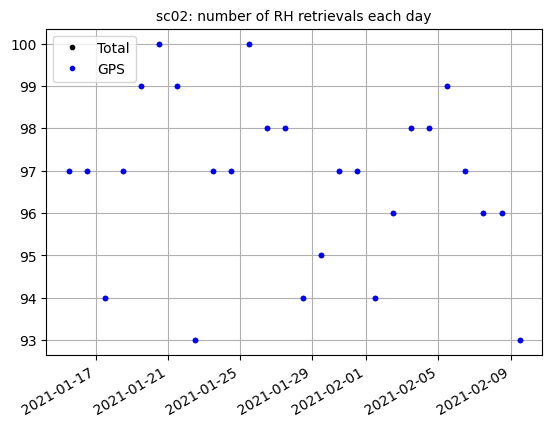

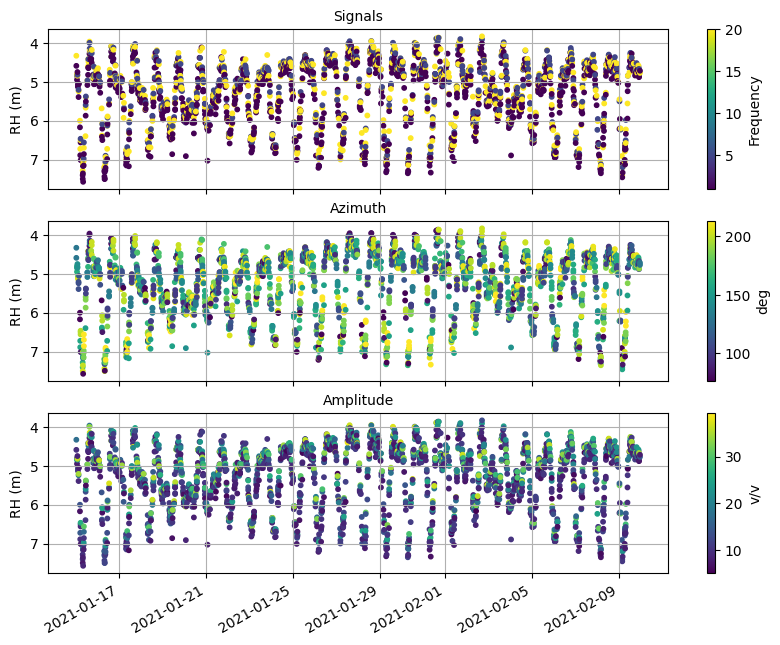

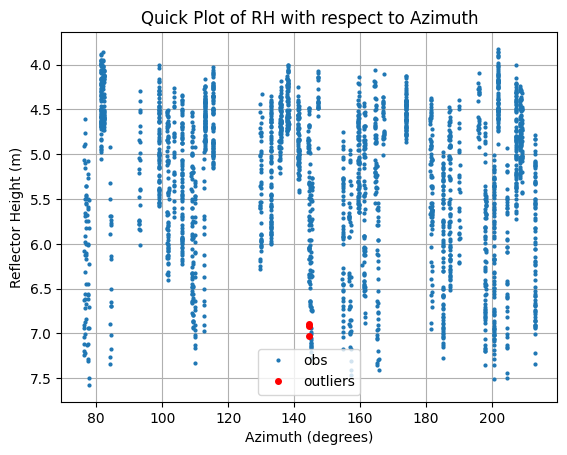

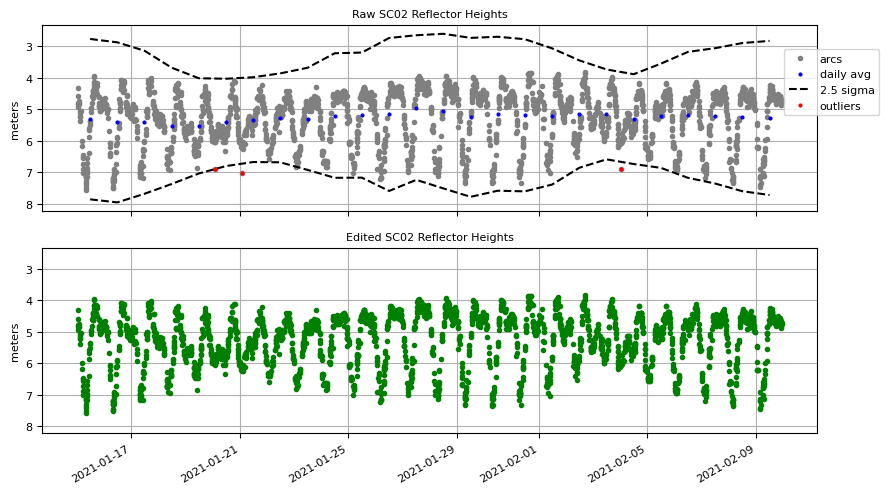

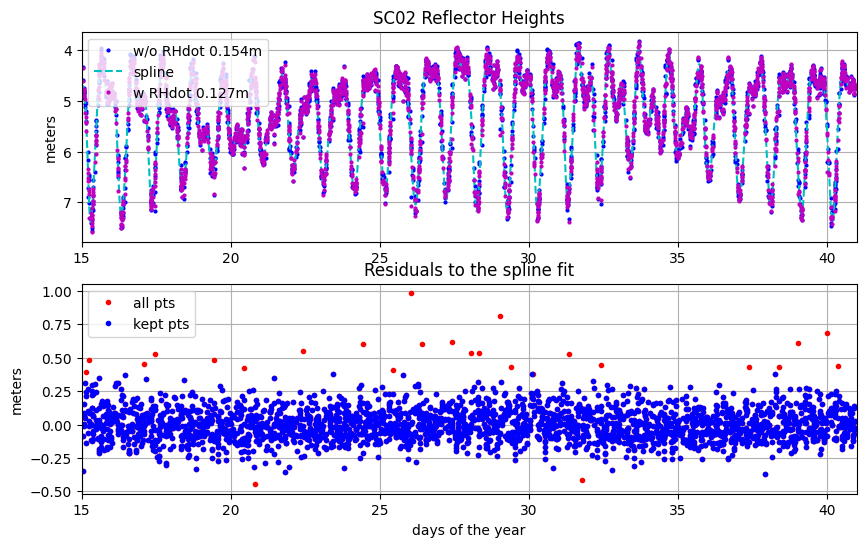

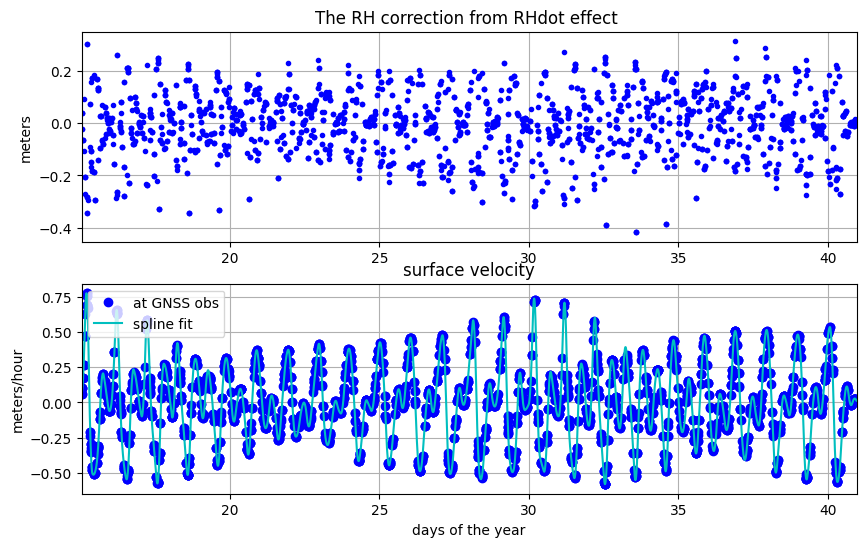

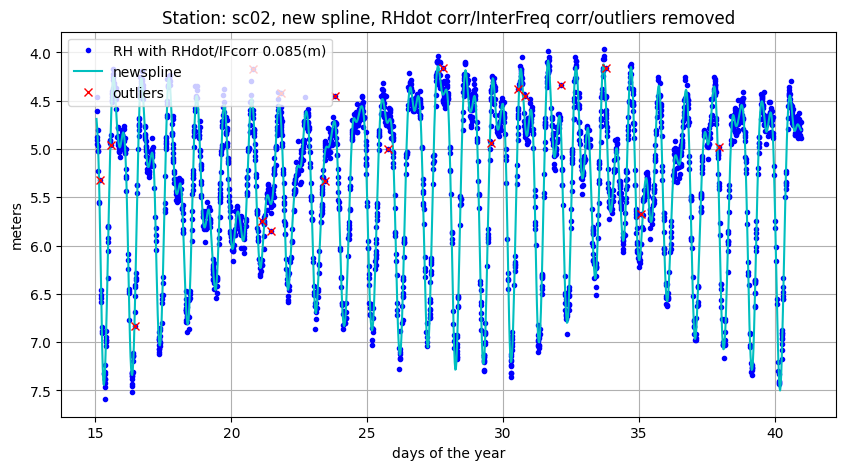

In [12]:
subdaily('sc02', 2021)

This is a standard Lomb Scargle analysis of reflection data at sc02.
Multiple authors have recommended using different analysis strategies, and 
you are most definitely encouraged to look at using these techniques. In most cases
smoothness strategies are used to improve the retrievals.  

I have recently posted Simon Williams tidal estimation code to python. I will do my best to add it to this 
package.

How well does this simple analyis compare 
to the [official NOAA tide gauge data stream?](https://tidesandcurrents.noaa.gov/stationhome.html?id=9449880)

You can download the NOAA data yourselves or use our utility:

In [13]:
from gnssrefl.download_tides import download_tides
download_tides('9449880', '20210115', '20210209')

9449880 20210115 20210209 None None False
I do not recognize your tide gauge network


We then compared the two series. 

<img src="../../../data/sc02-noaa.png" width=600>

<HR>

Here is a list of some of the publications using data from sc02. If you would like me to add more, please send them via email.

* [Larson, L&ouml;fgren, Haas, Coastal Sea Level Measurements Using A Single Geodetic GPS Receiver, 2011](https://www.kristinelarson.net/wp-content/uploads/2015/10/Larson_TideGauge.pdf)

* [Larson, Ray, and  Williams, A ten year comparison of water levels measured with a geodetic GPS receiver versus a conventional tide gauge, 2017](https://www.kristinelarson.net/wp-content/uploads/2015/12/LarsonRayWilliams-2017-FridayHarbor.pdf)

* [Purnell, Gomez, Chan, Strandberg, Hobiger, Quantifying the Uncertainty in Ground-Based GNSS-Reflectometry Sea Level Measurements, 2021](https://www.researchgate.net/publication/343091181_Quantifying_the_Uncertainty_in_Ground-Based_GNSS-Reflectometry_Sea_Level_Measurements)

* L&ouml;fgren, Haas, and Scherneck, 2014 Sea level time series and ocean tide analysis from multipath signals at five GPS sites in different parts of the world

* Wang, Zhang and Zhang, 2018 Sea level estimation from SNR data of geodetic receivers using wavelet analysis